In [1]:
import numpy as np
import scipy.stats as stats
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import urllib.request
from PIL import Image
from pydataset import data
from sklearn.model_selection import train_test_split
from sklearn.impute import SimpleImputer
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
from sklearn.feature_selection import chi2
from sklearn.preprocessing import MinMaxScaler, StandardScaler, RobustScaler, QuantileTransformer
from sklearn.feature_selection import SelectKBest, f_regression
from sklearn.linear_model import LinearRegression, TweedieRegressor, LassoLars
from sklearn.metrics import mean_squared_error, explained_variance_score
from sklearn.preprocessing import PolynomialFeatures
from acquire import *
from prepare import *
from explore import *
from wrangle_example import *
import env
import os
pd.options.mode.chained_assignment = None

In [2]:
df = data("swiss")

In [3]:
target = "Infant.Mortality"
train, validate, test, X_train, y_train, X_validate, y_validate, X_test, y_test = train_validate_test(df, target)

In [4]:
scaler = MinMaxScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_validate_scaled = pd.DataFrame(scaler.transform(X_validate), index=X_validate.index, columns=X_validate.columns)
X_test_scaled = pd.DataFrame(scaler.transform(X_test), index=X_test.index, columns=X_test.columns)

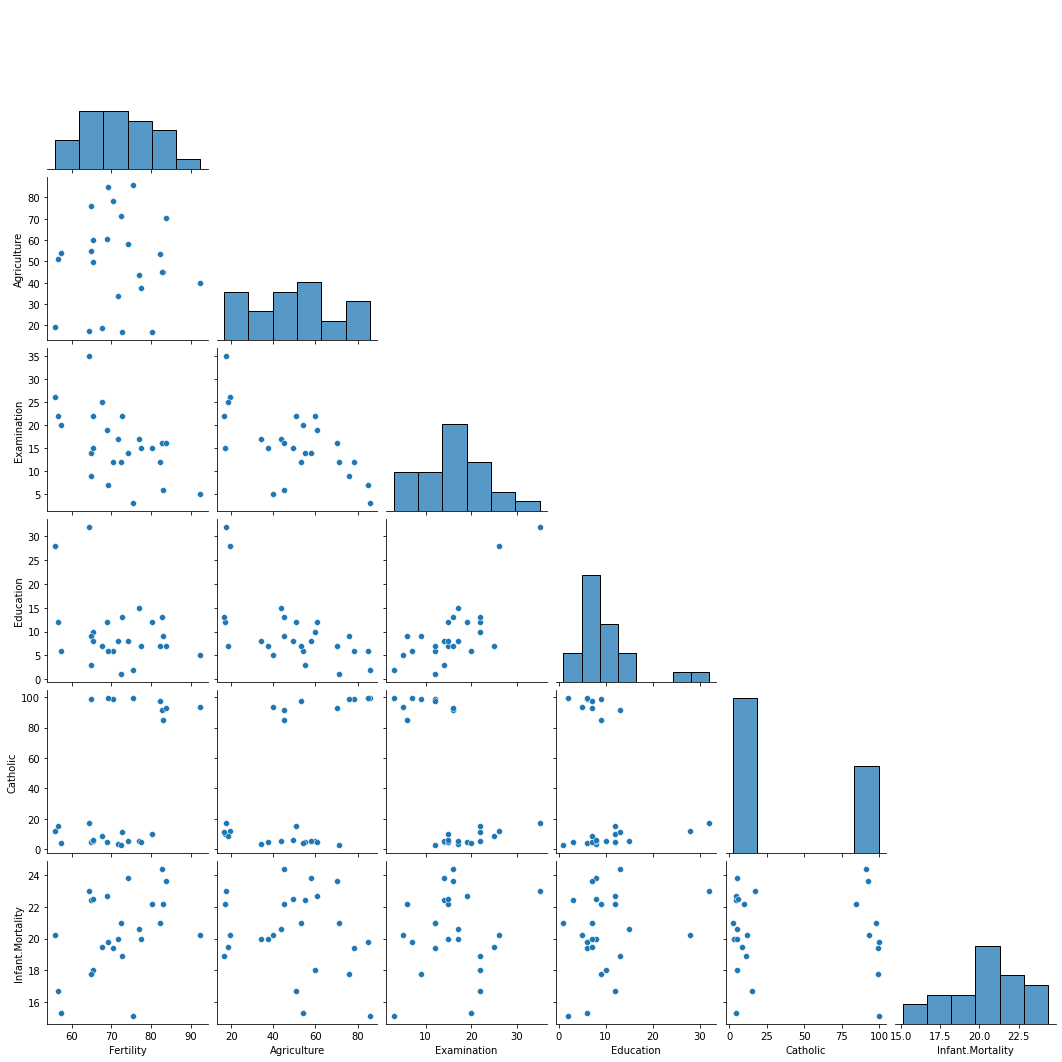

In [5]:
sns.pairplot(train, corner = True)

In [6]:
α = 0.05
r, p1 = stats.pearsonr(train['Fertility'], train['Infant.Mortality'])
r, p2 = stats.pearsonr(train['Catholic'], train['Infant.Mortality'])
print(p1 < α)
print(p2 < α)

True
False


In [7]:
bestest = SelectKBest(f_regression, k=3)
bestest.fit(X_train, y_train)
X_train.columns[bestest.get_support()]
k_columns = X_train.columns[bestest.get_support()].to_list()
print(k_columns)

['Fertility', 'Agriculture', 'Education']


/opt/homebrew/anaconda3/lib/python3.9/site-packages/sklearn/utils/validation.py:993: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [11]:
y_train['baseline_mean'] = y_train['Infant.Mortality'].mean()
y_train['baseline_median'] = y_train['Infant.Mortality'].median()

# scores:
rmse_mean = mean_squared_error(y_train['Infant.Mortality'],
                               y_train['baseline_mean'], squared=False)
rmse_med = mean_squared_error(y_train['Infant.Mortality'],
                               y_train['baseline_median'], squared=False)

display(rmse_mean, rmse_med)

y_validate['baseline_mean'] = y_validate['Infant.Mortality'].mean()

2.4545989489120217

2.463736998950984

In [10]:
metric_df = ([
    {
        'model': 'baseline_mean',
        'rmse': mean_squared_error(y_validate['Infant.Mortality'], y_validate.baseline_mean),
        'r^2': explained_variance_score(y_validate['Infant.Mortality'], y_validate.baseline_mean)
    
    }
    ])

metric_dfLin = model_metrics(LinearRegression(), 
                  X_train_scaled, 
                  y_train, 
                  X_validate_scaled, 
                  y_validate, 
                  metric_df)
display(pd.DataFrame(metric_dfLin))


metric_dfK = model_metrics(LinearRegression(), 
                  X_train_scaled[k_columns], 
                  y_train, 
                  X_validate_scaled[k_columns], 
                  y_validate, 
                  metric_dfLin)
display(pd.DataFrame(metric_dfK))

polyfeats = PolynomialFeatures(degree=2)
X_train_quad = polyfeats.fit_transform(X_train_scaled)
X_validate_quad = polyfeats.transform(X_validate_scaled)
metric_dfPoly = model_metrics(LinearRegression(), 
                  X_train_quad, 
                  y_train, 
                  X_validate_quad, 
                  y_validate, 
                  metric_dfK)
display(pd.DataFrame(metric_dfPoly))

(12, 5)
(12,)
           model       rmse       r^2
0  baseline_mean  17.302431  0.000000
1        vanilla   4.159748  0.021993
(12, 5)
(12,)
           model       rmse       r^2
0  baseline_mean  17.302431  0.000000
1        vanilla   4.159748  0.021993
2          kbest   3.857737  0.181445
(12, 5)
(12,)


,model,rmse,r^2
0,baseline_mean,17.302431,0.000000
1,vanilla,4.159748,0.021993
2,kbest,3.857737,0.181445
3,poly,7.352689,-2.115099
